In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
from shapely.geometry import Point, LineString
import hdbscan
import os
from dotenv import load_dotenv
import requests

%matplotlib inline

Download Capital Ring route buffer
The route and the buffer was done in QGIS
The buffer is 1000m, and allows to capture the POI in the areas along the route

In [2]:
#capital_ring_buffer = gpd.read_file('data/capital_ring_buffer.geojson')
#capital_ring_buffer.plot()

In [3]:
boro_shp = "data/source/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"
boro_gdf = gpd.read_file(boro_shp).to_crs('EPSG:27700')
boro_gdf.tail()

city_of_london_boro = (boro_gdf[boro_gdf['NAME'] == 'City of London'])

<Axes: >

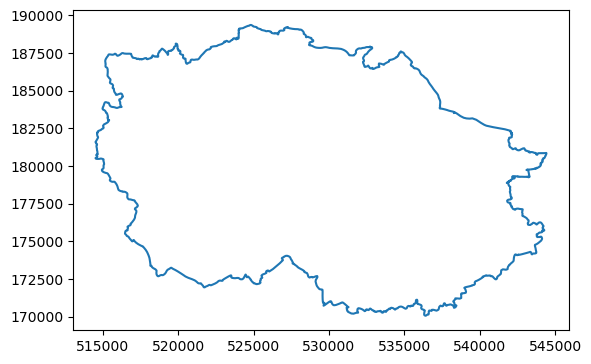

In [4]:
capital_ring_line = gpd.read_file('data/CR_reproject_smooth.geojson')
capital_ring_line.plot()

In [101]:
line = capital_ring_line.iloc[0].geometry  # Extract the LineString geometry

interval = 500  
distances = range(0, int(line.length), interval)
sampled_points = [line.interpolate(d) for d in distances]

capital_ring_line_sampled_points = gpd.GeoDataFrame(geometry=sampled_points, crs=capital_ring_line.crs)

/tmp/ipykernel_12622/891606438.py:8: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


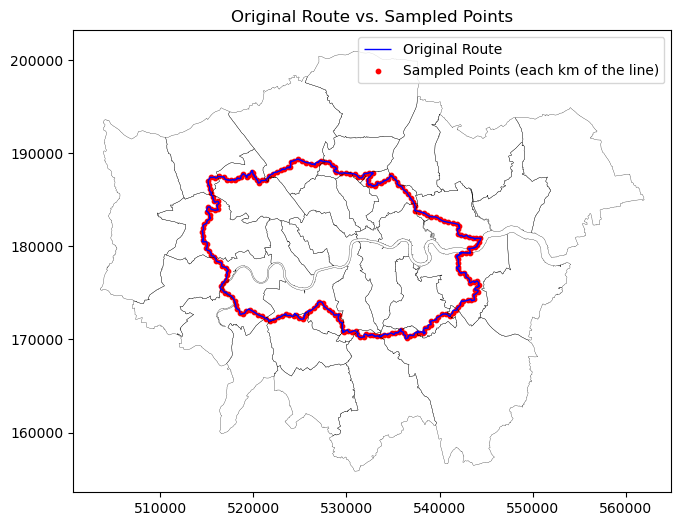

In [103]:
# Plot line and sampled points
fig, ax = plt.subplots(figsize=(10, 6))
capital_ring_line.plot(ax=ax, color='blue', linewidth=1, label="Original Route")
capital_ring_line_sampled_points.plot(ax=ax, color='red', markersize=10, label="Sampled Points (each km of the line)")
boro_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.2, label="City of London")

ax.set_aspect('equal')
plt.legend()
plt.title("Original Route vs. Sampled Points")
plt.show()

In [104]:
capital_ring_line_sampled_points.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  237 non-null    geometry
dtypes: geometry(1)
memory usage: 2.0 KB


In [105]:
# Load environment variables from the .env file
load_dotenv()
# Access the API key, secret key, and endpoint from environment variables
os_key = os.getenv('OS_API_KEY')
os_api_endpoint = 'https://api.os.uk/search/names/v1/nearest'

fq = 'LOCAL_TYPE:Hamlet LOCAL_TYPE:Suburban_Area LOCAL_TYPE:Village LOCAL_TYPE:Town LOCAL_TYPE:Other_Settlement' #which types of places to include
radius = 1000
point = "placeholder"

#print("Full URL:", OS_placenames_url)

In [106]:
places_df = pd.DataFrame()

In [107]:
for i in capital_ring_line_sampled_points['geometry']:
    sampled_point_string = (f"{i.x:.2f},{i.y:.2f}")
    point = sampled_point_string
    os_placenames_url = f"{os_api_endpoint}?point={point}&radius={radius}&fq={fq}&key={os_key}"

    os_response = requests.get(os_placenames_url)

    if os_response.status_code == 200:
        data = os_response.json()
        results = data.get('results', [])
    
        if results:
            df = pd.json_normalize(results)
            places_df = pd.concat([places_df, df], ignore_index=True)
        else:
            print("No results found for point:", point)
    else:
        print(f"Error: {os_response.status_code} - {os_response.text}")

No results found for point: 532439.95,187880.36
No results found for point: 524000.28,189016.34
No results found for point: 523994.01,188543.48
No results found for point: 521390.53,187155.29
No results found for point: 520923.09,187066.72
No results found for point: 520573.50,186791.69
No results found for point: 520350.71,187146.30
No results found for point: 519521.04,187649.10
No results found for point: 518944.17,187782.46
No results found for point: 516337.33,187494.40
No results found for point: 515790.45,184875.47
No results found for point: 516176.41,184458.29
No results found for point: 515901.31,183863.73
No results found for point: 515452.65,184037.82
No results found for point: 515104.00,184178.20
No results found for point: 515039.72,183734.96
No results found for point: 515313.73,183360.29
No results found for point: 515367.71,182998.38
No results found for point: 514604.32,181090.24
No results found for point: 515470.40,179115.74
No results found for point: 515832.95,17

In [108]:
places_df['geometry'] = places_df.apply(lambda row: Point(row['GAZETTEER_ENTRY.GEOMETRY_X'], row['GAZETTEER_ENTRY.GEOMETRY_Y']), axis=1)
places_gdf = gpd.GeoDataFrame(places_df, geometry='geometry')

#There are some duplicated entries
places_gdf = places_gdf.drop_duplicates(subset=['geometry'], keep='first')
print(f"Found {len(places_gdf)} places.")
places_gdf.head()

Found 80 places.


,GAZETTEER_ENTRY.ID,GAZETTEER_ENTRY.NAMES_URI,GAZETTEER_ENTRY.NAME1,GAZETTEER_ENTRY.TYPE,GAZETTEER_ENTRY.LOCAL_TYPE,GAZETTEER_ENTRY.GEOMETRY_X,GAZETTEER_ENTRY.GEOMETRY_Y,GAZETTEER_ENTRY.MOST_DETAIL_VIEW_RES,GAZETTEER_ENTRY.LEAST_DETAIL_VIEW_RES,GAZETTEER_ENTRY.MBR_XMIN,...,GAZETTEER_ENTRY.COUNTY_UNITARY,GAZETTEER_ENTRY.COUNTY_UNITARY_URI,GAZETTEER_ENTRY.COUNTY_UNITARY_TYPE,GAZETTEER_ENTRY.REGION,GAZETTEER_ENTRY.REGION_URI,GAZETTEER_ENTRY.COUNTRY,GAZETTEER_ENTRY.COUNTRY_URI,GAZETTEER_ENTRY.SAME_AS_GEONAMES,GAZETTEER_ENTRY.SAME_AS_DBPEDIA,geometry
0,osgb4000000074578781,http://data.ordnancesurvey.co.uk/id/4000000074...,North Woolwich,populatedPlace,Suburban Area,543058.0,179748.0,12000,25000,542550.0,...,Greater London,http://data.ordnancesurvey.co.uk/id/7000000000...,http://data.ordnancesurvey.co.uk/ontology/admi...,London,http://data.ordnancesurvey.co.uk/id/7000000000...,England,http://data.ordnancesurvey.co.uk/id/country/en...,http://sws.geonames.org/2641215,http://dbpedia.org/resource/North_Woolwich,POINT (543058 179748)
1,osgb4000000074302758,http://data.ordnancesurvey.co.uk/id/4000000074...,Royal Arsenal West,populatedPlace,Suburban Area,544046.0,179138.0,5000,25000,543650.0,...,Greater London,http://data.ordnancesurvey.co.uk/id/7000000000...,http://data.ordnancesurvey.co.uk/ontology/admi...,London,http://data.ordnancesurvey.co.uk/id/7000000000...,England,http://data.ordnancesurvey.co.uk/id/country/en...,NaN,NaN,POINT (544046 179138)
2,osgb4000000074820388,http://data.ordnancesurvey.co.uk/id/4000000074...,Cavendish Square,populatedPlace,Other Settlement,544260.0,180702.0,15000,25000,543997.0,...,Greater London,http://data.ordnancesurvey.co.uk/id/7000000000...,http://data.ordnancesurvey.co.uk/ontology/admi...,London,http://data.ordnancesurvey.co.uk/id/7000000000...,England,http://data.ordnancesurvey.co.uk/id/country/en...,NaN,NaN,POINT (544260 180702)
6,osgb4000000074578782,http://data.ordnancesurvey.co.uk/id/4000000074...,Cyprus,populatedPlace,Suburban Area,543493.0,180920.0,4000,25000,543159.0,...,Greater London,http://data.ordnancesurvey.co.uk/id/7000000000...,http://data.ordnancesurvey.co.uk/ontology/admi...,London,http://data.ordnancesurvey.co.uk/id/7000000000...,England,http://data.ordnancesurvey.co.uk/id/country/en...,NaN,NaN,POINT (543493 180920)
8,osgb4000000074579017,http://data.ordnancesurvey.co.uk/id/4000000074...,Beckton,populatedPlace,Suburban Area,542951.0,181665.0,20000,25000,541701.0,...,Greater London,http://data.ordnancesurvey.co.uk/id/7000000000...,http://data.ordnancesurvey.co.uk/ontology/admi...,London,http://data.ordnancesurvey.co.uk/id/7000000000...,England,http://data.ordnancesurvey.co.uk/id/country/en...,http://sws.geonames.org/2656052,http://dbpedia.org/resource/Beckton,POINT (542951 181665)


/tmp/ipykernel_12622/3585290458.py:8: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


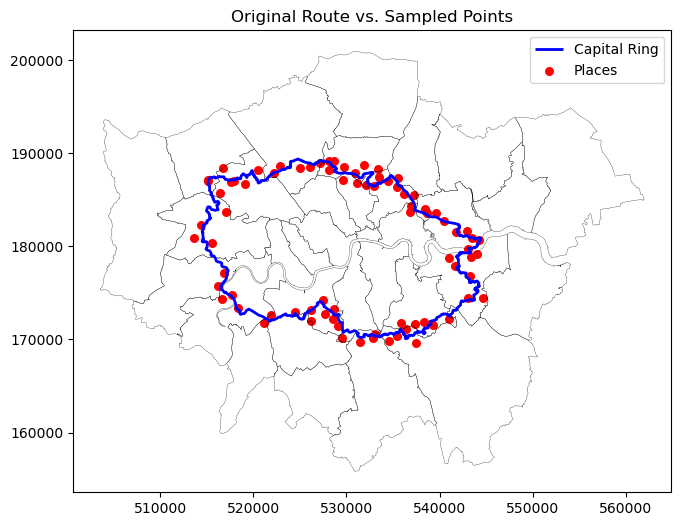

In [109]:
# Plot line and sampled points
fig, ax = plt.subplots(figsize=(10, 6))
capital_ring_line.plot(ax=ax, color='blue', linewidth=2, label="Capital Ring")
places_gdf.plot(ax=ax, color='red', markersize=30, label="Places")
boro_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.2, label="City of London")

ax.set_aspect('equal')
plt.legend()
plt.title("Original Route vs. Sampled Points")
plt.show()

In [110]:
print(places_gdf.iloc[2]["geometry"])
places_gdf.set_crs('EPSG:27700', inplace=True)
print(places_gdf.crs)

POINT (544260 180702)
EPSG:27700


In [111]:
#Setting params for Wikipedia API
wiki_api_endpoint = 'https://en.wikipedia.org/w/api.php?action=query&list=geosearch'
radius = 1000

#Reprojecting gdf to fit the API requirements
places_gdf_wgs84 = places_gdf.to_crs(4258)
print(places_gdf_wgs84.crs)
print(places_gdf_wgs84.iloc[2]["geometry"]) #ensuring the coordinates have transformed

EPSG:4258
POINT (0.0772798084689046 51.50684263876633)


In [117]:
# Getting data from Wikipedia API
wiki_df = pd.DataFrame()

for index, i in enumerate(places_gdf_wgs84["geometry"]):
    lat = i.y
    lon = i.x
    wiki_url = f"{wiki_api_endpoint}&gsradius={radius}&gscoord={lat}|{lon}&gslimit=500&format=json"
    wiki_response = requests.get(wiki_url)
#    print(Wiki_url)
#    print(Wiki_response.status_code)
    if wiki_response.status_code == 200:
        data = wiki_response.json()
        results = data.get('query', []).get('geosearch', [])   

        # print(data.keys())
        # print(results)
        if results:
            df = pd.json_normalize(results)
            df['place_index'] = index
            wiki_df = pd.concat([wiki_df, df], ignore_index=True)
#            print(wiki_df.shape)
        else:
            print("No results found for point:", i)
    else:
        print(f"Error: {wiki_response.status_code} - {wiki_response.text}")
#    if index == 5:  # Stop after the item N - for testing
#       break

In [118]:
wiki_df

,pageid,ns,title,lat,lon,dist,primary,place_index
0,353306,0,Woolwich foot tunnel,51.498790,0.061650,144.9,,0
1,8609500,0,North Woolwich railway station,51.499400,0.062300,209.1,,0
2,10737078,0,Royal Docks Heritage Railway,51.499400,0.062300,209.1,,0
3,51859566,0,"St John's Church, North Woolwich",51.500702,0.058687,244.5,,0
4,1326226,0,North Woolwich Old Station Museum,51.499722,0.063056,272.0,,0
...,...,...,...,...,...,...,...,...
1663,353306,0,Woolwich foot tunnel,51.498790,0.061650,934.1,,79
1664,54744293,0,HyMag,51.494200,0.076000,960.8,,79
1665,75312486,0,Repository Woods,51.484500,0.053400,963.2,,79
1666,8609500,0,North Woolwich railway station,51.499400,0.062300,996.6,,79


In [241]:
wiki_df["geometry"] = wiki_df.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
wiki_gdf = gpd.GeoDataFrame(wiki_df, geometry="geometry")
wiki_gdf.set_crs(4258, inplace=True)
wiki_gdf = wiki_gdf.to_crs(27700)

wiki_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1668 entries, 0 to 1667
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   pageid       1668 non-null   int64   
 1   ns           1668 non-null   int64   
 2   title        1668 non-null   object  
 3   lat          1668 non-null   float64 
 4   lon          1668 non-null   float64 
 5   dist         1668 non-null   float64 
 6   primary      1668 non-null   object  
 7   place_index  1668 non-null   int64   
 8   geometry     1668 non-null   geometry
dtypes: float64(3), geometry(1), int64(3), object(2)
memory usage: 117.4+ KB


/tmp/ipykernel_12622/2311409148.py:9: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


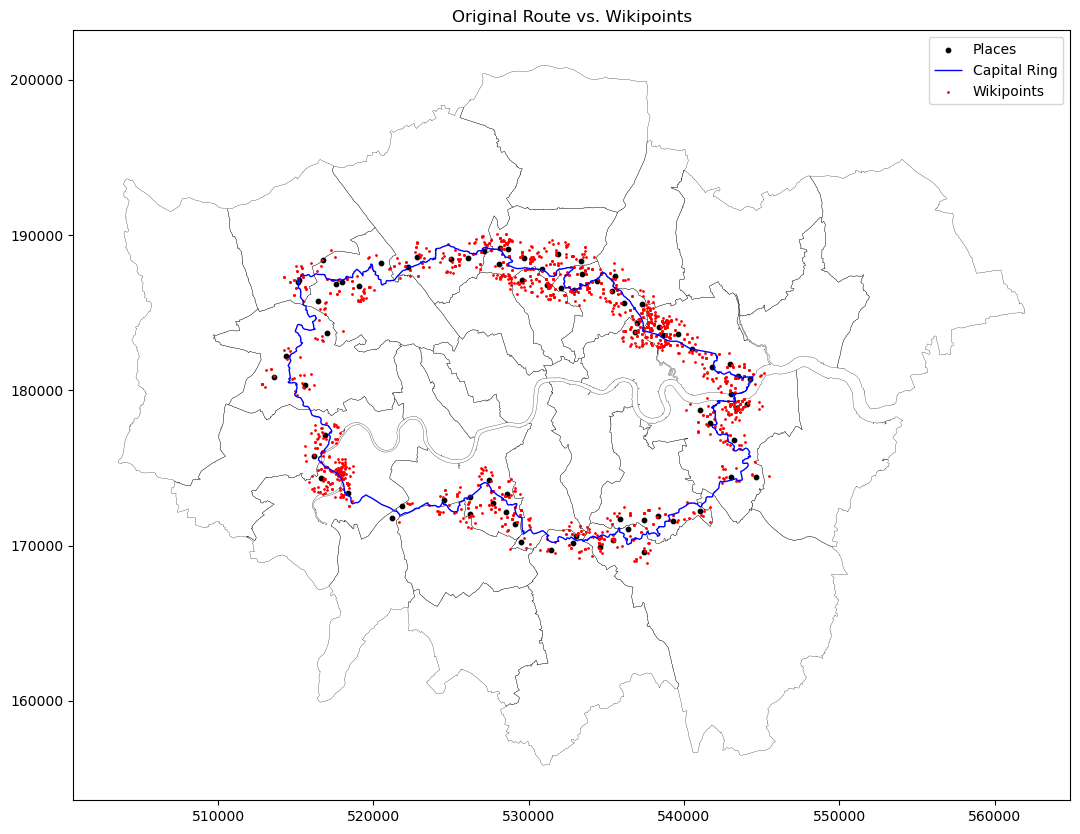

In [115]:
# Plot line and sampled points
fig, ax = plt.subplots(figsize=(20, 10))
places_gdf.plot(ax=ax, color='black', markersize=10, label="Places")
capital_ring_line.plot(ax=ax, color='blue', linewidth=1, label="Capital Ring")
boro_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.2, label="City of London")
wiki_gdf.plot(ax=ax, color='red', markersize=1, label="Wikipoints")

ax.set_aspect('equal')
plt.legend()
plt.title("Original Route vs. Wikipoints")
plt.show()

In [25]:
wiki_gdf

,pageid,ns,title,lat,lon,dist,primary,place_index,geometry
0,353306,0,Woolwich foot tunnel,51.498790,0.061650,144.9,,0,POINT (543200.622 179775.886)
1,8609500,0,North Woolwich railway station,51.499400,0.062300,209.1,,0,POINT (543243.823 179844.989)
3,51859566,0,"St John's Church, North Woolwich",51.500702,0.058687,244.5,,0,POINT (542988.988 179982.71)
4,1326226,0,North Woolwich Old Station Museum,51.499722,0.063056,272.0,,0,POINT (543295.252 179882.298)
5,387712,0,North Woolwich,51.501000,0.058000,291.1,,0,POINT (542940.375 180014.506)
...,...,...,...,...,...,...,...,...,...
1345,16795418,0,Angerstein Wharf,51.493600,0.020500,754.0,,64,POINT (540360.508 179119.095)
1346,38947659,0,Royal Greenwich Trust School,51.491600,0.041300,803.0,,64,POINT (541810.534 178936.763)
1349,30154806,0,Holborn College,51.491800,0.042100,861.8,,64,POINT (541865.446 178960.553)
1350,76947,0,Thames Barrier,51.496944,0.036667,883.5,,64,POINT (541472.348 179522.104)


The points are too close to each other. We need to perfom cluster analysis to determine, which points are part of which place. We observe:
- The route goes through places with different number of wikipoints;
- There are some outliers;
- The clusters for a place could be irregularly-shaped, because they are affected by the real-world conditions;
- We can approximate the number of clusters, however,
- The points are arranged around the place point, but there are many overlaps, and
- There may be points with little or no wikipoints.

The tested clustering techniques included hdbscan, k-means with forced N of clusters, and Voronoi-Based Clustering. The latter proved to most accurately separate wikipoints between places. Although this doesn't take into account densities, we could argue that someone who vitist the place might want to understand/see the whole area, and is not constrained by having to walk under 1km.

In [242]:
from scipy.spatial import Voronoi, KDTree

place_coords = np.array([[p.x, p.y] for p in places_gdf.geometry])
wiki_coords = np.array([[p.x, p.y] for p in wiki_gdf.geometry])

# Assign each wikipoint to the nearest place using a KDTree
tree = KDTree(place_coords)
_, nearest_place = tree.query(wiki_coords)

wiki_gdf["cluster"] = nearest_place  # Assign cluster based on nearest place index


In [243]:
wiki_gdf['cluster'].value_counts()

cluster
9     105
79     66
49     66
8      60
18     42
     ... 
43      5
61      4
75      4
52      4
51      1
Name: count, Length: 80, dtype: int64

In [244]:
wiki_gdf

,pageid,ns,title,lat,lon,dist,primary,place_index,geometry,cluster
0,353306,0,Woolwich foot tunnel,51.498790,0.061650,144.9,,0,POINT (543200.622 179775.886),0
1,8609500,0,North Woolwich railway station,51.499400,0.062300,209.1,,0,POINT (543243.823 179844.989),0
2,10737078,0,Royal Docks Heritage Railway,51.499400,0.062300,209.1,,0,POINT (543243.823 179844.989),0
3,51859566,0,"St John's Church, North Woolwich",51.500702,0.058687,244.5,,0,POINT (542988.988 179982.71),0
4,1326226,0,North Woolwich Old Station Museum,51.499722,0.063056,272.0,,0,POINT (543295.252 179882.298),0
...,...,...,...,...,...,...,...,...,...,...
1663,353306,0,Woolwich foot tunnel,51.498790,0.061650,934.1,,79,POINT (543200.622 179775.886),0
1664,54744293,0,HyMag,51.494200,0.076000,960.8,,79,POINT (544211.07 179293.639),1
1665,75312486,0,Repository Woods,51.484500,0.053400,963.2,,79,POINT (542672.622 178170.743),79
1666,8609500,0,North Woolwich railway station,51.499400,0.062300,996.6,,79,POINT (543243.823 179844.989),0


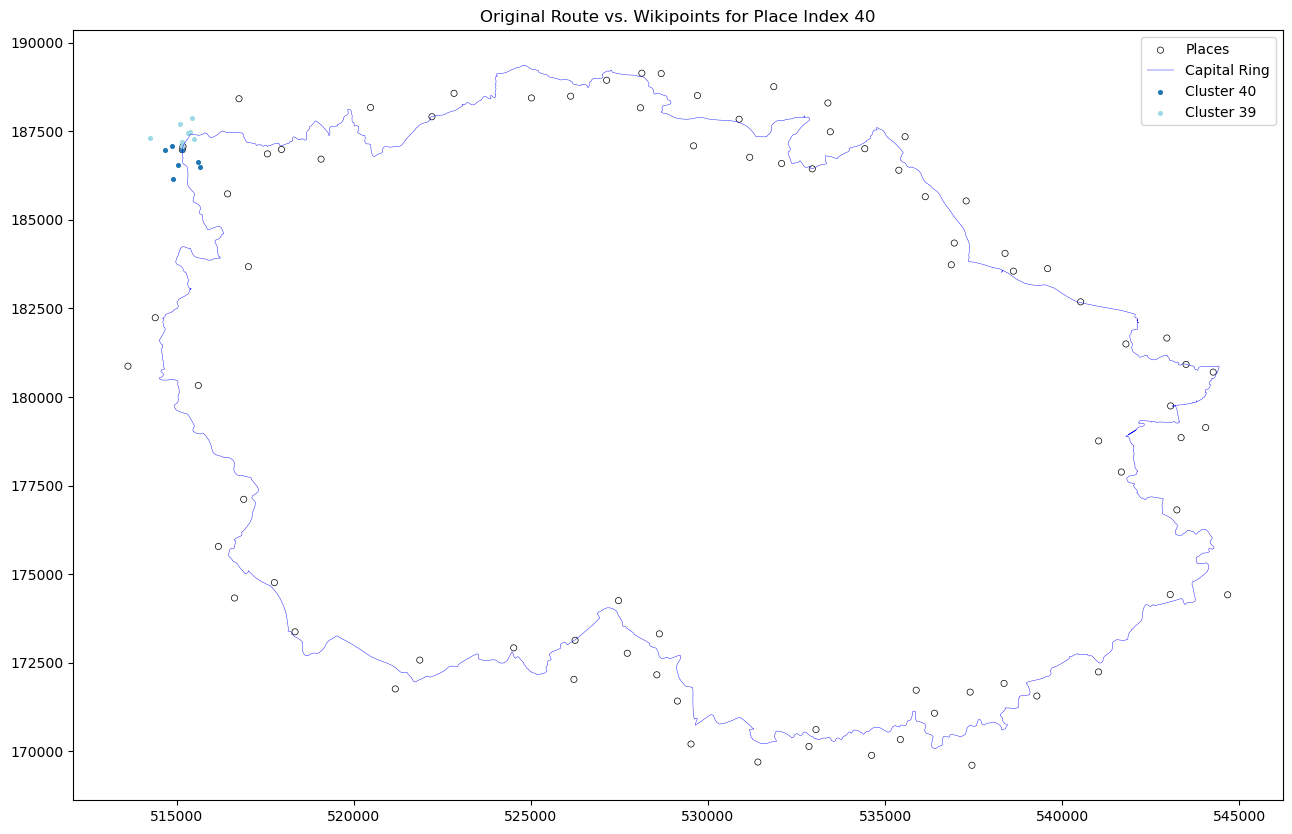

In [245]:
#________________________________________________________________________________________________________________
#Testing the clusters
#________________________________________________________________________________________________________________

# Initialize the plot
fig, ax = plt.subplots(figsize=(20, 10))

# Plot places_gdf points
places_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, markersize=20, label="Places")

# Plot the Capital Ring Line
capital_ring_line.plot(ax=ax, color='blue', linewidth=0.3, label="Capital Ring")

# Set a random place_index
random_state = random.randint(0, 79)

# Get the matching rows for the selected place_index
matching_wiki_points = wiki_gdf[wiki_gdf['place_index'] == random_state]

# Generate a color map based on the unique clusters of these points
unique_clusters = matching_wiki_points['cluster'].unique()
colormap = plt.get_cmap('tab20', len(unique_clusters))  # Generate distinct colors for each cluster

# Plot the matching wikipoints
for cluster in unique_clusters:
    # Get the cluster points
    cluster_points = matching_wiki_points[matching_wiki_points['cluster'] == cluster]
    
    # Set color based on cluster or black for outliers
    if cluster != -1:  # Non-outliers
        cluster_color = colormap(unique_clusters.tolist().index(cluster))
        cluster_points.plot(ax=ax, color=cluster_color, markersize=7, label=f"Cluster {cluster}")
    else:  # Outliers
        cluster_points.plot(ax=ax, color='black', markersize=1, label="Outliers")

# Highlight all matching wikipoints for the selected place_index
#matching_wiki_points.plot(ax=ax, color='red', markersize=5, label="Wikipoints")

# Final adjustments and plot settings
ax.set_aspect('equal')
plt.legend()
plt.title(f"Original Route vs. Wikipoints for Place Index {random_state}")
plt.show()

In [247]:
#________________________________________________________________________________________________________________
#For each cluster, we remove overlapping points
#________________________________________________________________________________________________________________

print("Original wiki_gdf length:", len(wiki_gdf))
deduped_rows = []

for cluster, group in wiki_gdf.groupby("cluster"):
    # Drop duplicates within group
    group_deduped = group.drop_duplicates(subset=['geometry'], keep='first')
    deduped_rows.append(group_deduped)

wiki_gdf_dedupped = gpd.GeoDataFrame(pd.concat(deduped_rows, ignore_index=True))
print("Deduplicated wiki_gdf length:", len(wiki_gdf_dedupped))

Original wiki_gdf length: 1668
Deduplicated wiki_gdf length: 1082


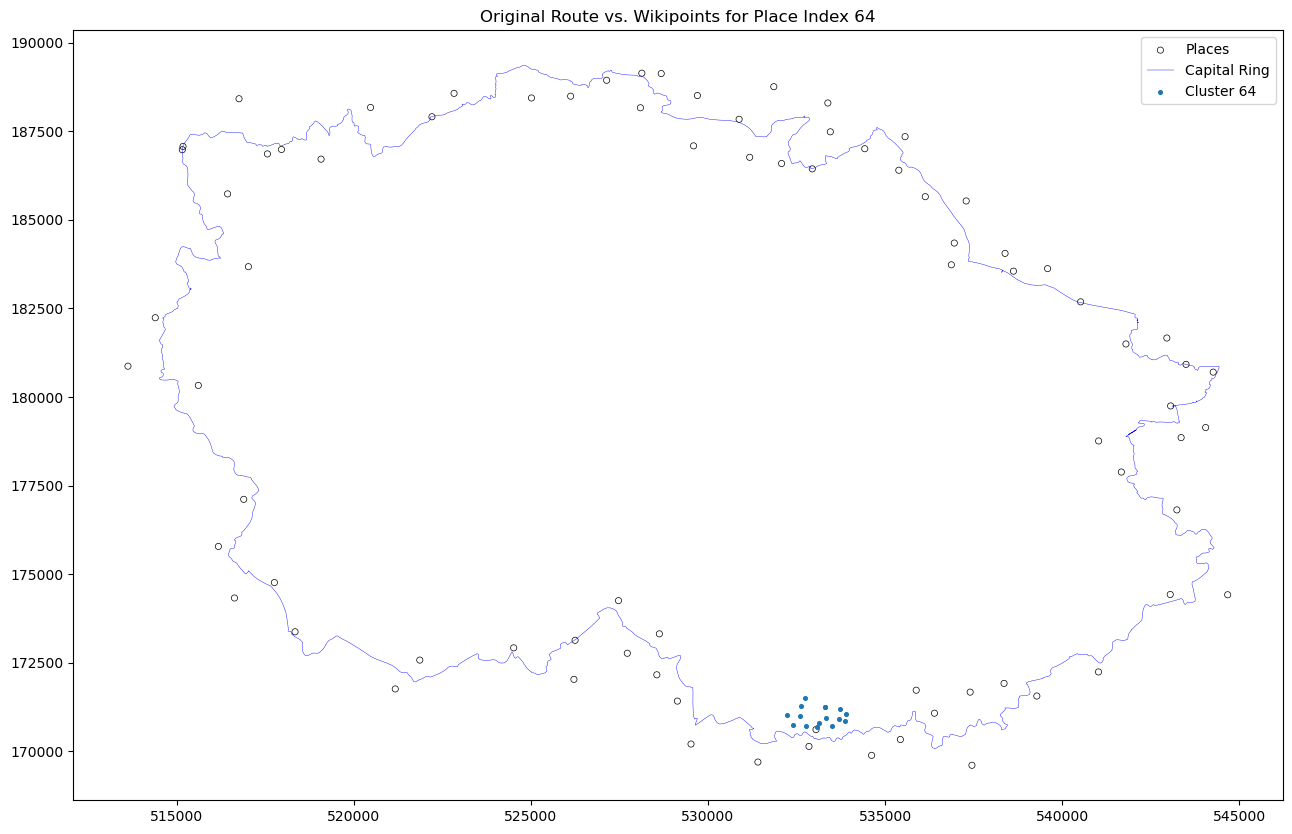

In [253]:
#________________________________________________________________________________________________________________
#Testing that the sorting by 'cluster' column works as intended.
#The value of this column corresponds to the index of the places_gdf
#________________________________________________________________________________________________________________

# Initialize the plot
fig, ax = plt.subplots(figsize=(20, 10))

# Plot places_gdf points
places_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, markersize=20, label="Places")

# Plot the Capital Ring Line
capital_ring_line.plot(ax=ax, color='blue', linewidth=0.3, label="Capital Ring")

# Set a random place_index
random_state = random.randint(0, 79)

# Get the matching rows for the selected place_index
matching_wiki_points = wiki_gdf_dedupped[wiki_gdf_dedupped['cluster'] == random_state]

# Generate a color map based on the unique clusters of these points
unique_clusters = matching_wiki_points['cluster'].unique()
colormap = plt.get_cmap('tab20', len(unique_clusters))  # Generate distinct colors for each cluster

# Plot the matching wikipoints
for cluster in unique_clusters:
    # Get the cluster points
    cluster_points = matching_wiki_points[matching_wiki_points['cluster'] == cluster]
    
    # Set color based on cluster or black for outliers
    if cluster != -1:  # Non-outliers
        cluster_color = colormap(unique_clusters.tolist().index(cluster))
        cluster_points.plot(ax=ax, color=cluster_color, markersize=7, label=f"Cluster {cluster}")
    else:  # Outliers
        cluster_points.plot(ax=ax, color='black', markersize=1, label="Outliers")

# Highlight all matching wikipoints for the selected place_index
#matching_wiki_points.plot(ax=ax, color='red', markersize=5, label="Wikipoints")

# Final adjustments and plot settings
ax.set_aspect('equal')
plt.legend()
plt.title(f"Original Route vs. Wikipoints for Place Index {random_state}")
plt.show()

In [254]:
#________________________________________________________________________________________________________________
#Parsing categories
#________________________________________________________________________________________________________________

"""
    parse.py
    MediaWiki API Demos
    Demo of `Parse` module: Parse content of a page
    MIT License
"""

wiki_cat = requests.Session()
wiki_cat_url = "https://en.wikipedia.org/w/api.php"

In [332]:
#________________________________________________________________________________________________________________
#Trying the selected point - TEST
#________________________________________________________________________________________________________________
test_place_point_index = 40
wikipoints_subset = wiki_gdf_dedupped[wiki_gdf_dedupped['cluster'] == test_place_point_index].reset_index(drop=True)
wiki_cat_df = pd.DataFrame()

In [333]:
wiki_cat_df

""


In [334]:
for index,row in wikipoints_subset.iterrows():
    pageid = row['pageid']
    wiki_cat_params = {
        "action": "parse",
        "pageid": pageid,
        "prop": "categories",
        "format": "json"
    }
    
    R = wiki_cat.get(url=wiki_cat_url, params=wiki_cat_params)
    full_url = wiki_cat_url + "?" + "&".join([f"{key}={value}" for key, value in wiki_cat_params.items()])
    print("Requesting URL:", full_url)
    
    if R.status_code == 200:
        data = R.json()
        results = data.get("parse")   

        if results:
            df = pd.json_normalize(results)
            wiki_cat_df = pd.concat([wiki_cat_df, df], ignore_index=True)
    else:
        print(f"Error: {R.status_code} - {R.text}")

Requesting URL: https://en.wikipedia.org/w/api.php?action=parse&pageid=3771814&prop=categories&format=json
Requesting URL: https://en.wikipedia.org/w/api.php?action=parse&pageid=1091394&prop=categories&format=json
Requesting URL: https://en.wikipedia.org/w/api.php?action=parse&pageid=5815931&prop=categories&format=json
Requesting URL: https://en.wikipedia.org/w/api.php?action=parse&pageid=15929992&prop=categories&format=json
Requesting URL: https://en.wikipedia.org/w/api.php?action=parse&pageid=94427&prop=categories&format=json
Requesting URL: https://en.wikipedia.org/w/api.php?action=parse&pageid=2490805&prop=categories&format=json
Requesting URL: https://en.wikipedia.org/w/api.php?action=parse&pageid=1086616&prop=categories&format=json


In [335]:
wiki_cat_df

,title,pageid,categories
0,Harrow on the Hill Urban District,3771814,"[{'sortkey': '', 'hidden': '', '*': 'Webarchiv..."
1,John Lyon School,1091394,"[{'sortkey': '', 'hidden': '', '*': 'Pages_usi..."
2,Roxeth,5815931,"[{'sortkey': '', 'hidden': '', '*': 'Pages_usi..."
3,St Dominic's Sixth Form College,15929992,"[{'sortkey': '', 'hidden': '', '*': 'Pages_usi..."
4,London Borough of Harrow,94427,"[{'sortkey': '', 'hidden': '', '*': 'Pages_usi..."
5,Harrow on the Hill,2490805,"[{'sortkey': '', 'hidden': '', '*': 'Pages_usi..."
6,Orley Farm School,1086616,"[{'sortkey': '', 'hidden': '', '*': 'Pages_usi..."


In [343]:
#wiki_cat_df_unpacked = pd.DataFrame()

In [346]:
for index,row in wiki_cat_df.iterrows():
    cat_list = []
    row.info()
    for i in row["categories"]:
        if isinstance(i, dict) and 'hidden' not in i.keys():
            cat_list.append(i["*"])
    row["categories"] = cat_list
#    wiki_cat_df_unpacked = pd.concat([wiki_cat_df_unpacked, row], ignore_index=True)
    print(f"Categories are: {cat_list}")

<class 'pandas.core.series.Series'>
Index: 3 entries, title to categories
Series name: 0
Non-Null Count  Dtype 
--------------  ----- 
3 non-null      object
dtypes: object(1)
memory usage: 156.0+ bytes
Categories are: ['History_of_the_London_Borough_of_Harrow', 'Districts_of_England_created_by_the_Local_Government_Act_1894', 'History_of_local_government_in_Middlesex', 'Harrow_on_the_Hill']
<class 'pandas.core.series.Series'>
Index: 3 entries, title to categories
Series name: 1
Non-Null Count  Dtype 
--------------  ----- 
3 non-null      object
dtypes: object(1)
memory usage: 156.0+ bytes
Categories are: ['Educational_institutions_established_in_1876', 'Private_schools_in_the_London_Borough_of_Harrow', "Private_boys'_schools_in_London", "Member_schools_of_the_Headmasters'_and_Headmistresses'_Conference", 'Harrow_School', '1876_establishments_in_England']
<class 'pandas.core.series.Series'>
Index: 3 entries, title to categories
Series name: 2
Non-Null Count  Dtype 
--------------  ----

In [345]:
wiki_cat_df_unpacked

,0
0,Harrow on the Hill Urban District
1,3771814
2,"[History_of_the_London_Borough_of_Harrow, Dist..."
3,John Lyon School
4,1091394
5,"[Educational_institutions_established_in_1876,..."
6,Roxeth
7,5815931
8,"[Districts_of_the_London_Borough_of_Harrow, Ar..."
9,St Dominic's Sixth Form College


In [341]:
wiki_cat_df

,title,pageid,categories
0,Harrow on the Hill Urban District,3771814,"[{'sortkey': '', 'hidden': '', '*': 'Webarchiv..."
1,John Lyon School,1091394,"[{'sortkey': '', 'hidden': '', '*': 'Pages_usi..."
2,Roxeth,5815931,"[{'sortkey': '', 'hidden': '', '*': 'Pages_usi..."
3,St Dominic's Sixth Form College,15929992,"[{'sortkey': '', 'hidden': '', '*': 'Pages_usi..."
4,London Borough of Harrow,94427,"[{'sortkey': '', 'hidden': '', '*': 'Pages_usi..."
5,Harrow on the Hill,2490805,"[{'sortkey': '', 'hidden': '', '*': 'Pages_usi..."
6,Orley Farm School,1086616,"[{'sortkey': '', 'hidden': '', '*': 'Pages_usi..."


In [342]:
cat_list = []
for i in wiki_cat_df["categories"]:
    if isinstance(i, dict) and 'hidden' not in i.keys():
        cat_list.append(row["*"])
    wiki_cat_df.at[i, "categories"] = cat_list
print(f"Categories are: {cat_list}")

InvalidIndexError: You can only assign a scalar value not a <class 'list'>

In [277]:
wiki_cat_df_test.info()

<class 'pandas.core.series.Series'>
Index: 3 entries, title to categories
Series name: 0
Non-Null Count  Dtype 
--------------  ----- 
3 non-null      object
dtypes: object(1)
memory usage: 156.0+ bytes


In [291]:
cat_list = []
for i in wiki_cat_df_test["categories"]:
    if 'hidden' not in i.keys():
        print(i)
        cat_list.append(i["*"])

{'sortkey': '', '*': 'History_of_the_London_Borough_of_Harrow'}
{'sortkey': '', '*': 'Districts_of_England_created_by_the_Local_Government_Act_1894'}
{'sortkey': '', '*': 'History_of_local_government_in_Middlesex'}
{'sortkey': '', '*': 'Harrow_on_the_Hill'}


In [283]:
cat_list

['History_of_the_London_Borough_of_Harrow',
 'Districts_of_England_created_by_the_Local_Government_Act_1894',
 'History_of_local_government_in_Middlesex',
 'Harrow_on_the_Hill']